In [409]:
import loginkey

from selenium import webdriver
from selenium.webdriver.common.by import By

from bs4 import BeautifulSoup

from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support.select import Select
from selenium.webdriver.common.keys import Keys

from urllib.parse import unquote

import re

import time as time

In [22]:
class element_not_have_css_class(object):
    """An expectation for checking that an element has a particular css class.

    locator - used to find the element
    returns the WebElement once it has the particular css class
    """
    def __init__(self, locator, css_class):
        self.locator = locator
        self.css_class = css_class

    def __call__(self, driver):
        element = driver.find_element(*self.locator)   # Finding the referenced element
        if self.css_class not in element.get_attribute("class"):
            return element
        else:
            return False

In [437]:
def initialize_driver():
    
    from selenium.webdriver.chrome.options import Options
    
    chrome_options = Options()
    chrome_options.add_argument("--headless")
    
    print('initializing driver...')
    
    driver = webdriver.Chrome(options=chrome_options)
    driver.get('https://www.artsy.net/')
    
    print('loaded artsy.net, waiting to log in...')
    
    wait = WebDriverWait(driver, 10)
    time.sleep(2)

    button = driver.find_element(By.XPATH, '/html/body/div[2]/div/div/div[1]/div/header/div/nav/div[1]/a[2]')
    driver.execute_script("arguments[0].click();", button)

    # user = loginkey.user
    # password = loginkey.password

    user = 'michaeljroth815@gmail.com'
    password = 'YudBYiLj$e7u2Xq'
    
    time.sleep(2)
    
    print('logging in...')
    
    wait.until(EC.element_to_be_clickable((By.CLASS_NAME, 'hgOWHr')))

    driver.find_element(By.CLASS_NAME, 'hgOWHr').click()
    driver.find_element(By.XPATH, "//input[@name='email']").send_keys(user)
    driver.find_element(By.CLASS_NAME, 'jGXstL').click()
    driver.find_element(By.XPATH, "//input[@name='password']").send_keys(password)
    driver.find_element(By.XPATH, "//button[@type='submit']").click()
    
    print('log in sucessful...')
    
    return driver

In [527]:
def auction_scrape(driver, list_of_artists):
    
    max_pages = 100
    
    wait = WebDriverWait(driver, 10)
    auction_results = []
    count = 0
    
    for artist in list_of_artists:

        url = f'https://www.artsy.net/artist/{artist}/auction-results?metric=in'

        driver.get(url)

        time.sleep(2)

        wait.until(EC.element_to_be_clickable((By.XPATH,'//select')))

        select_element = driver.find_elements(By.XPATH,'//select')
        for i in range(len(select_element)):
            select_object = Select(select_element[i])
            try:
                select_object.select_by_value('PRICE_AND_DATE_DESC')
                break
            except:
                pass

        for i in range(max_pages):
            driver.switch_to.window(driver.window_handles[0])

            soup = BeautifulSoup(driver.page_source)

            loading_container = soup.find(class_='LoadingArea__Container-sc-1qecphp-2')
            title_divs = loading_container.find_all(class_='jvPMUs')
            image_divs = loading_container.find_all(class_='fvrqBk')
            info_divs = loading_container.find_all(class_='icNtnl')
            price_divs = loading_container.find_all(class_='iZqizk')

            for i in range(9):
                try:
                    title = title_divs[i*2].find_all(class_='ldlHGe')[0].text
                except:
                    title = float("nan")
                try:
                    image_url = image_divs[i].find('img').get('src')
                    pattern = re.compile("(http|ftp|https)")
                    find_2nd = pattern.findall(image_url)
                    find_http = pattern.split(find_2nd[0][2])
                    image_url = ''.join(find_http[1:])
                except:
                    image_url = float("nan")
                try:
                    medium = info_divs[i].find_all(class_='buodgj')[1].contents[0]
                except:
                    medium = float("nan")
                try:
                    dimensions = info_divs[i].find_all(class_='buodgj')[1].contents[-1]
                except:
                    medium = float("nan")
                try:
                    estimate = info_divs[i].find_all(class_='buodgj')[3].contents[0]
                except:
                    estimate = float("nan")
                try:
                    realized_price = info_divs[i].find_all(class_='buodgj')[7].contents[0]
                except:
                    realized_price = float("nan")
                try:
                    try:
                        price = price_divs[i].find(class_='eHKyyH').text
                    except:
                        price = price_divs[i].find(class_='ldlHGe').text
                    price = int(price.replace('US$', '').replace(',',''))
                except:
                    price = None
                result = {
                    'artist_slug': artist,
                    'title': title,
                    'image_url': image_url,
                    'medium': medium,
                    'dimensions': dimensions,
                    'estimate': estimate,
                    'realized_price': realized_price,
                    'price': price
                }
                
                auction_results.append(result)
                print(f'{count} total objects scraped', end='\r')
                count += 1

            try:

                driver.find_element(By.LINK_TEXT, 'Next').click()

                element = wait.until(element_not_have_css_class((By.CLASS_NAME, 'beISLe'), "loading"))
            except:
                break

    driver.close() 
    
    return auction_results

In [528]:
artists = ['gustav-klimt', 'francisco-de-goya', 'rembrandt-van-rijn',
       'leonardo-da-vinci', 'edouard-manet']


In [529]:
driver = initialize_driver()
print('waiting to scrape...')
time.sleep(10)
print('scraping...')
results = auction_scrape(driver, artists)
print('scraping complete.')

initializing driver...
loaded artsy.net, waiting to log in...
logging in...
log in sucessful...
waiting to scrape...
scraping...
scraping complete. scraped


In [530]:
import pandas as pd

results_df = pd.DataFrame(results)

In [531]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2448 entries, 0 to 2447
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   artist_slug     2448 non-null   object 
 1   title           2439 non-null   object 
 2   image_url       1859 non-null   object 
 3   medium          2439 non-null   object 
 4   dimensions      2448 non-null   object 
 5   estimate        2439 non-null   object 
 6   realized_price  2439 non-null   object 
 7   price           2319 non-null   float64
dtypes: float64(1), object(7)
memory usage: 153.1+ KB


In [552]:
results_df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,2319.0,506705.188875,1.324051e+07,29.0,3500.0,13750.0,49508.0,450312500.0


In [554]:
results_df.query('medium == "Painting"').describe().T

,count,mean,std,min,25%,50%,75%,max
price,133.0,7.591785e+06,5.496519e+07,235.0,7242.0,49000.0,653005.0,450312500.0


In [555]:
results_df.query('medium == "Painting"').groupby('artist_slug').describe()

price                                                \
                   count          mean           std     min       25%   
artist_slug                                                              
edouard-manet       42.0  1.851799e+06  3.946822e+06   235.0  238125.0   
francisco-de-goya   25.0  3.098864e+05  6.811413e+05   813.0    7242.0   
gustav-klimt        16.0  1.369880e+06  2.174801e+06  3000.0   68612.0   
leonardo-da-vinci   46.0  1.961317e+07  9.284011e+07  1011.0    2614.0   
rembrandt-van-rijn   4.0  1.520950e+04  6.791371e+03  9328.0    9328.0   

                                                       
                         50%         75%          max  
artist_slug                                            
edouard-manet       639313.5  2152912.25   24000000.0  
francisco-de-goya    24000.0    75903.00    2198000.0  
gustav-klimt        344500.0  1349997.50    7437500.0  
leonardo-da-vinci    12528.5    35835.75  450312500.0  
rembrandt-van-rijn   15209.5    21091.00      21091.0

In [551]:
results_df.query('medium == "Painting"').dropna(subset=['title']).isna().sum()

artist_slug        0
title              0
image_url         68
medium             0
dimensions         0
estimate           0
realized_price     0
price             19
dtype: int64

In [543]:
results_df.query('artist_slug == "leonardo-da-vinci"').sort_values('price')

,artist_slug,title,image_url,medium,dimensions,estimate,realized_price,price
1888,leonardo-da-vinci,Last Supper by Pierre Edouard Gautier d'Agoty,NaN,Print,,US$600–US$900,US$325,325.0
1954,leonardo-da-vinci,Last Supper by Pierre Edouard Gautier d'Agoty,NaN,Print,,US$600–US$900,US$325,325.0
1884,leonardo-da-vinci,Self-portrait,,Print,19.0 x 24.3 cm,"JPY ¥70,000–¥100,000","JPY ¥80,000",730.0
1953,leonardo-da-vinci,Self-portrait,,Print,19.0 x 24.3 cm,"JPY ¥70,000–¥100,000","JPY ¥80,000",730.0
1951,leonardo-da-vinci,Madonna,NaN,Print,24.5 x 32.0 cm,"JPY ¥80,000–¥120,000","JPY ¥90,000",822.0
...,...,...,...,...,...,...,...,...
1989,leonardo-da-vinci,Mona Lisa,NaN,[],55.88 x 76.2 in,Estimate not available,Price not available,NaN
1996,leonardo-da-vinci,Esquisse pour St.Jerome,NaN,Painting,71.12 x 101.6 in,Estimate not available,Price not available,NaN
2004,leonardo-da-vinci,NaN,NaN,NaN,195 x 122 mm,NaN,NaN,NaN
2005,leonardo-da-vinci,NaN,NaN,NaN,195 x 122 mm,NaN,NaN,NaN


In [534]:
results_df.dropna(subset=['title'])

,artist_slug,title,image_url,medium,dimensions,estimate,realized_price,price
0,gustav-klimt,Zusammengekauerter und nach rechts stehender F...,,Work on Paper,447 by 307 mm,"£28,000–£35,000","£85,680",102004.0
1,gustav-klimt,”Zwei Studien eines mit hochgezogenem rechten ...,,Work on Paper,31.0 x 41.2 cm,"€10,000–€15,000","€11,250",12095.0
2,gustav-klimt,"Mit Strümpfen, die rechte Hand an der Schulter",,Work on Paper,29.0 x 56.0 cm,"US$25,000–US$35,000","US$56,700",56700.0
3,gustav-klimt,"Stehend von vorne, die Rechte abgestützt (Bild...",,Work on Paper,37.5 x 57.0 cm,"£30,000–£50,000","£60,480",75841.0
4,gustav-klimt,Auf dem Bauch liegender Akt mit Pelzboa (Recli...,,Work on Paper,37.5 by 56.5 cm.\n14¾ by 22¼ in.\n52.5 by 72 c...,"€50,000–€70,000","€75,600",82392.0
...,...,...,...,...,...,...,...,...
2437,edouard-manet,Still life of assorted flowers in brass vase,NaN,[],63.5 x 76.2 in,Estimate not available,£900,1449.0
2438,edouard-manet,Troncs D'Arbres,NaN,[],38.1 x 45.72 in,Estimate not available,"£30,000",43028.0
2439,edouard-manet,La rue Mosnier au Paveurs,NaN,Painting,81.28 x 66.04 in,Estimate not available,"£7,000,000",10062500.0
2440,edouard-manet,Le Repos,NaN,[],50.8 x 33.02 in,Estimate not available,"US$550,000",550000.0


<AxesSubplot:>

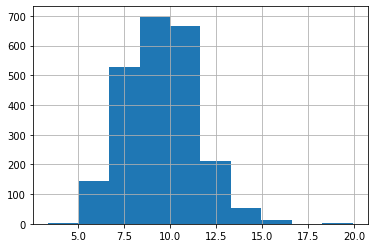

In [559]:
import numpy as np

np.log(results_df.price).hist()

In [ ]:
#need to get rid of login info